In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import xgboost as xgb
import seaborn as sns
from scipy.stats import norm, skew #for some statistics
from scipy import stats

In [2]:
CIF = pd.read_csv('data/TBN_CIF.csv',index_col='CUST_NO')  # 顧客基本資料
RECENT_DT = pd.read_csv('data/TBN_RECENT_DT.csv', na_values='a',index_col='CUST_NO')  #近期投資行為

CUST_BEHAVIOR = pd.read_csv('data/TBN_CUST_BEHAVIOR.csv', index_col='CUST_NO') #顧客瀏覽網頁行為
CUST_BEHAVIOR_raw = pd.read_csv('data/TBN_CUST_BEHAVIOR.csv') #顧客瀏覽網頁行為


CC_APPLY = pd.read_csv('data/TBN_CC_APPLY.csv') # 信用卡, priority 10
FX_TXN = pd.read_csv('data/TBN_FX_TXN.csv')    # 外匯, priority 1
LN_APPLY = pd.read_csv('data/TBN_LN_APPLY.csv')  # 信貸, priority 20
WM_TXN = pd.read_csv('data/TBN_WM_TXN.csv')  # 信託, priority 20

TBN = pd.read_csv('data/TBN_Y_ZERO.csv')  # 信託, priority 20

In [3]:
print('CIF shape:( %i, %i)'%(CIF.shape[0],CIF.shape[1]))
print('CUST_BEHAVIOR shape:( %i, %i)'%(CUST_BEHAVIOR.shape[0],CUST_BEHAVIOR.shape[1]))
print('CUST_BEHAVIOR_raw shape:( %i, %i)'%(CUST_BEHAVIOR_raw.shape[0],CUST_BEHAVIOR_raw.shape[1]))
print('RECENT_DT. shape:( %i, %i)'%(RECENT_DT.shape[0],RECENT_DT.shape[1]))
print('CC_APPLY shape:( %i, %i)'%(CC_APPLY.shape[0],CC_APPLY.shape[1]))
print('FX_TXN shape:( %i, %i)'%(FX_TXN.shape[0],FX_TXN.shape[1]))
print('LN_APPLY shape:( %i, %i)'%(LN_APPLY.shape[0],LN_APPLY.shape[1]))
print('WM_TXN shape:( %i, %i)'%(WM_TXN.shape[0],WM_TXN.shape[1]))
print('TBN shape:( %i, %i)'%(TBN.shape[0],TBN.shape[1]))

CIF shape:( 187679, 7)
CUST_BEHAVIOR shape:( 2209864, 2)
CUST_BEHAVIOR_raw shape:( 2209864, 3)
RECENT_DT. shape:( 195000, 4)
CC_APPLY shape:( 54393, 2)
FX_TXN shape:( 507185, 3)
LN_APPLY shape:( 6741, 4)
WM_TXN shape:( 36763, 5)
TBN shape:( 30000, 5)


In [4]:
print(CIF.head())
CIF.loc['W7ADZSWYXEMHB7JQ']

                  AGE  CHILDREN_CNT  CUST_START_DT  EDU_CODE GENDER_CODE  \
CUST_NO                                                                    
UFUIMEGMK2KTIWI4    1           NaN            2.0       NaN         NaN   
3HJN2X_LGBHBKILI    3           0.0         9393.0       NaN         NaN   
MNEZK2O3OE-JHYBW    4           0.0         2912.0       3.0           M   
W7ADZSWYXEMHB7JQ    4           0.0         8332.0       5.0           M   
ODB6BA6ORHL2UYZE    4           0.0          744.0       3.0           M   

                  INCOME_RANGE_CODE  WORK_MTHS  
CUST_NO                                         
UFUIMEGMK2KTIWI4                NaN        NaN  
3HJN2X_LGBHBKILI                1.0        NaN  
MNEZK2O3OE-JHYBW                2.0        2.0  
W7ADZSWYXEMHB7JQ                2.0        1.0  
ODB6BA6ORHL2UYZE                2.0        1.0  


AGE                     4
CHILDREN_CNT            0
CUST_START_DT        8332
EDU_CODE                5
GENDER_CODE             M
INCOME_RANGE_CODE       2
WORK_MTHS               1
Name: W7ADZSWYXEMHB7JQ, dtype: object

In [5]:
print(RECENT_DT.head())
RECENT_DT['CC_RECENT_DT']=RECENT_DT['CC_RECENT_DT'].fillna(0)
RECENT_DT['FX_RECENT_DT']=RECENT_DT['FX_RECENT_DT'].fillna(0)
RECENT_DT['LN_RECENT_DT']=RECENT_DT['LN_RECENT_DT'].fillna(0)
RECENT_DT['WM_RECENT_DT']=RECENT_DT['WM_RECENT_DT'].fillna(0)
print('CC_RECENT_DT: %.1f, %.1f '%(min(RECENT_DT['CC_RECENT_DT']), max(RECENT_DT['CC_RECENT_DT'])))
print('FX_RECENT_DT: %.1f, %.1f '%(min(RECENT_DT['FX_RECENT_DT']), max(RECENT_DT['FX_RECENT_DT'])))
print('LN_RECENT_DT: %.1f, %.1f '%(min(RECENT_DT['LN_RECENT_DT']), max(RECENT_DT['LN_RECENT_DT'])))
print('WM_RECENT_DT: %.1f, %.1f '%(min(RECENT_DT['WM_RECENT_DT']), max(RECENT_DT['WM_RECENT_DT'])))

                  CC_RECENT_DT  FX_RECENT_DT  LN_RECENT_DT  WM_RECENT_DT
CUST_NO                                                                 
UTYYSZRISTNCDCGU           NaN           NaN           NaN           NaN
4IKO82Q8ZY2X2VAK           NaN           NaN           NaN           NaN
EP2OI8DQMZFAHBEA        9214.0           NaN           NaN           NaN
83A1N8HQ4CLT56IY        9393.0        9438.0           NaN        9368.0
SURN2CDMNHCL4SJC        7318.0        9445.0           NaN        8154.0
CC_RECENT_DT: 0.0, 9447.0 
FX_RECENT_DT: 0.0, 9447.0 
LN_RECENT_DT: 0.0, 9445.0 
WM_RECENT_DT: 0.0, 9445.0 


In [6]:
print(CUST_BEHAVIOR.head())
print('VISITDATE: %.1f, %.1f '%(min(CUST_BEHAVIOR['VISITDATE']), max(CUST_BEHAVIOR['VISITDATE'])))

                  VISITDATE                                               PAGE
CUST_NO                                                                       
AZTHNWQ_LXMGIMYG       9462      http://www.esunbank.com.tw/gygrt/e2c/iougkjr/
AZTHNWQ_LXMGIMYG       9528  https://www.esunbank.com.tw/gygrt/wgdqth/gsxri...
3PY428CHUQBULFIG       9458  https://www.esunbank.com.tw/edrn/deoxt/rgws-cg...
JVPD1QUJWVLMZU8S       9457  https://www.esunbank.com.tw/edrn/pgusordq/fgpo...
JVPD1QUJWVLMZU8S       9485  https://www.esunbank.com.tw/edrn/pgusordq/fgpo...
VISITDATE: 9448.0, 9567.0 


In [7]:
print(CC_APPLY.head())
print('CC_TXN_DT: %i, %i '%(min(CC_APPLY['TXN_DT']), max(CC_APPLY['TXN_DT'])))

            CUST_NO  TXN_DT
0  8H_N_K5ICM4NU7OG    9519
1  HXD9GCY3SPIYLJS0    9451
2  KSBOZ-TBPUDD9NMO    9502
3  MU8ROCNFDGSL0HJC    9549
4  RGZZAUSNHNXXESM4    9561
CC_TXN_DT: 9448, 9567 


In [8]:
print(FX_TXN.head())
print('FX_TXN_DT: %i, %i '%(min(FX_TXN['TXN_DT']), max(FX_TXN['TXN_DT'])))

            CUST_NO  TXN_DT  FX_TXN_AMT
0  MNEZK2O3OE-JHYBW    9562       26006
1  MNEZK2O3OE-JHYBW    9567       26009
2  MNEZK2O3OE-JHYBW    9557       26793
3  MNEZK2O3OE-JHYBW    9452       25981
4  MNEZK2O3OE-JHYBW    9451       26002
FX_TXN_DT: 9448, 9567 


In [9]:
print(LN_APPLY.head())
print('LN_TXN_DT: %i, %i '%(min(LN_APPLY['TXN_DT']), max(LN_APPLY['TXN_DT'])))

            CUST_NO  TXN_DT   LN_AMT LN_USE
0  JZKEGB1J3FEPXGWA    9455   904731     06
1  TKTH9UXLWDVLA8E4    9472  1218170     01
2  KZ0XPLZI-NGTHTDE    9505  1183088     01
3  BT5INBWYOZQK8CDY    9457   848097     05
4  Z5H7IUX8VPUMWWY8    9473   848097     01
LN_TXN_DT: 9449, 9567 


In [10]:
print(WM_TXN.head())
print('WM_TXN_DT: %i, %i '%(min(WM_TXN['TXN_DT']), max(WM_TXN['TXN_DT'])))

            CUST_NO  TXN_DT  CUST_RISK_CODE  INVEST_TYPE_CODE  WM_TXN_AMT
0  83A1N8HQ4CLT56IY    9476             3.0                 2      270684
1  B8ZNLMVWJOHCJ7LY    9546             3.0                 2      254794
2  -O2NVMT-W0WJHEAQ    9521             3.0                 2      797298
3  NRVZ15KRUYBNVLX0    9490             4.0                 2      439191
4  GAP3CQTQ-3K8OAHM    9513             4.0                 2      137037
WM_TXN_DT: 9449, 9567 


## 1. 訓練資料集時間為 9447+1 (9448) ~ 9447+120 (9567) 之間，共120日之間產品交易/申請資訊．
## 2. 本次比賽是請參賽者預測在9447+121 (9568) ~ 9447+150 (9597) 時間區間內（共30日），顧客在四個產品線CC_IND, FX_IND, LN_IND, WM_IND是否會進行交易，若預測顧客該時間內於任一產品線交易一次以上，該產品線的預測值為1，否則為0．例如: 顧客序號12345，預測信用卡核卡1次，外匯交易2次，沒有信貸申請，信託交易3次，該筆預測資料應為: 12345,1,1,0,1 ．
## 3. TBN_Y_ZERO.csv則是提供給參賽者做為上傳範例資料檔使用，內部預設值是全部為0．

In [11]:
a=CC_APPLY.groupby('CUST_NO', sort=False).max()

In [12]:
a
#a.loc['B8ZNLMVWJOHCJ7LY']

,TXN_DT
CUST_NO,
8H_N_K5ICM4NU7OG,9519
HXD9GCY3SPIYLJS0,9451
KSBOZ-TBPUDD9NMO,9502
MU8ROCNFDGSL0HJC,9549
RGZZAUSNHNXXESM4,9561
RK8IOV3CW0LRIQGA,9546
XUNRR-4BPG0AZC6E,9456
XHDBEGXDXKLJS8SK,9459
ARREKAB79XDMMPEE,9464


In [13]:
CC = pd.concat((CIF,RECENT_DT), axis=1, join_axes=[RECENT_DT.index], ignore_index=False)
print(CC.loc['SURN2CDMNHCL4SJC'])
#print(WM[WM['CUST_RISK_CODE']>0])
#print(WM[WM['WM_TXN_AMT']>0])
CC.shape

AGE                     4
CHILDREN_CNT            0
CUST_START_DT        4677
EDU_CODE                2
GENDER_CODE             M
INCOME_RANGE_CODE       2
WORK_MTHS               1
CC_RECENT_DT         7318
FX_RECENT_DT         9445
LN_RECENT_DT            0
WM_RECENT_DT         8154
Name: SURN2CDMNHCL4SJC, dtype: object


(195000, 11)

In [14]:


print(max(CUST_BEHAVIOR['VISITDATE']))
CUST_B_over30 = CUST_BEHAVIOR[CUST_BEHAVIOR['VISITDATE']<=(max(CUST_BEHAVIOR['VISITDATE'])-30)]
CUST_B_30_60 = CUST_BEHAVIOR[(CUST_BEHAVIOR['VISITDATE']<=(max(CUST_BEHAVIOR['VISITDATE'])-30)) & (CUST_BEHAVIOR['VISITDATE']>(max(CUST_BEHAVIOR['VISITDATE'])-60))]
CUST_B_60_90 = CUST_BEHAVIOR[(CUST_BEHAVIOR['VISITDATE']<=(max(CUST_BEHAVIOR['VISITDATE'])-60)) & (CUST_BEHAVIOR['VISITDATE']>(max(CUST_BEHAVIOR['VISITDATE'])-90))]
CUST_B_90_120 = CUST_BEHAVIOR[(CUST_BEHAVIOR['VISITDATE']<=(max(CUST_BEHAVIOR['VISITDATE'])-90)) & (CUST_BEHAVIOR['VISITDATE']>(max(CUST_BEHAVIOR['VISITDATE'])-120))]
CUST_B_in30 = CUST_BEHAVIOR[CUST_BEHAVIOR['VISITDATE']>(max(CUST_BEHAVIOR['VISITDATE'])-30)]
print('Over 30 days, max day: %i' %max(CUST_B_over30['VISITDATE']))
print(' 30~60  days, max day: %i' %max(CUST_B_30_60['VISITDATE']))
print(' 60~90  days, max day: %i' %max(CUST_B_60_90['VISITDATE']))
print(' 90~120  days, max day: %i' %max(CUST_B_90_120['VISITDATE']))
print('  in 30 days, min day: %i' %min(CUST_B_in30['VISITDATE']))
#print(CUST_B_over30.shape)
print(CUST_B_30_60.shape)
print(CUST_B_60_90.shape)
print(CUST_B_90_120.shape)
print(CUST_B_in30.shape)

CUST_B_30_90 = CUST_BEHAVIOR[(CUST_BEHAVIOR['VISITDATE']<=(max(CUST_BEHAVIOR['VISITDATE'])-30)) & (CUST_BEHAVIOR['VISITDATE']>(max(CUST_BEHAVIOR['VISITDATE'])-90))]
print(' 30~90  days, max day: %i' %max(CUST_B_30_90['VISITDATE']))
print(CUST_B_30_90.shape)

9567
Over 30 days, max day: 9537
 30~60  days, max day: 9537
 60~90  days, max day: 9507
 90~120  days, max day: 9477
  in 30 days, min day: 9538
(649891, 2)
(601314, 2)
(760446, 2)
(198213, 2)
 30~90  days, max day: 9537
(1251205, 2)


In [15]:

print(max(CUST_BEHAVIOR_raw['VISITDATE']))
CUST_B_over30_raw = CUST_BEHAVIOR_raw[CUST_BEHAVIOR_raw['VISITDATE']<=(max(CUST_BEHAVIOR_raw['VISITDATE'])-30)]
CUST_B_30_60_raw = CUST_BEHAVIOR_raw[(CUST_BEHAVIOR_raw['VISITDATE']<=(max(CUST_BEHAVIOR_raw['VISITDATE'])-30)) & (CUST_BEHAVIOR_raw['VISITDATE']>(max(CUST_BEHAVIOR_raw['VISITDATE'])-60))]
CUST_B_60_90_raw = CUST_BEHAVIOR_raw[(CUST_BEHAVIOR_raw['VISITDATE']<=(max(CUST_BEHAVIOR_raw['VISITDATE'])-60)) & (CUST_BEHAVIOR_raw['VISITDATE']>(max(CUST_BEHAVIOR_raw['VISITDATE'])-90))]
CUST_B_90_120_raw = CUST_BEHAVIOR_raw[(CUST_BEHAVIOR_raw['VISITDATE']<=(max(CUST_BEHAVIOR_raw['VISITDATE'])-90)) & (CUST_BEHAVIOR_raw['VISITDATE']>(max(CUST_BEHAVIOR_raw['VISITDATE'])-120))]
CUST_B_in30_raw = CUST_BEHAVIOR_raw[CUST_BEHAVIOR_raw['VISITDATE']>(max(CUST_BEHAVIOR_raw['VISITDATE'])-30)]
print('Over 30 days, max day: %i' %max(CUST_B_over30_raw['VISITDATE']))
print(' 30~60  days, max day: %i' %max(CUST_B_30_60_raw['VISITDATE']))
print(' 60~90  days, max day: %i' %max(CUST_B_60_90_raw['VISITDATE']))
print(' 90~120  days, max day: %i' %max(CUST_B_90_120_raw['VISITDATE']))
print('  in 30 days, min day: %i' %min(CUST_B_in30_raw['VISITDATE']))
#print(CUST_B_over30.shape)
print(CUST_B_30_60_raw.shape)
print(CUST_B_60_90_raw.shape)
print(CUST_B_90_120_raw.shape)
print(CUST_B_in30_raw.shape)

9567
Over 30 days, max day: 9537
 30~60  days, max day: 9537
 60~90  days, max day: 9507
 90~120  days, max day: 9477
  in 30 days, min day: 9538
(649891, 3)
(601314, 3)
(760446, 3)
(198213, 3)


In [16]:
CUST_BEHAVIOR.shape

(2209864, 2)

In [17]:
#total page count
PAGE_count = CUST_BEHAVIOR.groupby('PAGE').max()
PAGE_count.shape

(782, 1)

In [18]:
# 瀏覽網頁總人數
CUST_BEHAVIOR_gb = CUST_BEHAVIOR.groupby(('CUST_NO'), sort=False).max()
CUST_BEHAVIOR_gb.shape 

(195000, 2)

In [19]:
# 30~120天瀏覽人數
CUST_B_over30_gb = CUST_B_over30.groupby(('CUST_NO'), sort=False).max()
CUST_B_over30_gb.shape

(180000, 2)

In [24]:
# 30~60 天瀏覽人數
CUST_B_30_60_gb = CUST_B_30_60.groupby(('CUST_NO'), sort=False).max()
print(CUST_B_30_60_gb.shape)
# CUST_B_30_60_gb.head()

(86867, 2)


In [21]:
# 60~90 天瀏覽人數
CUST_B_60_90_gb = CUST_B_60_90.groupby(('CUST_NO'), sort=False).max()
CUST_B_60_90_gb.shape

(86911, 2)

In [22]:
# 90~120 天瀏覽人數
CUST_B_90_120_gb = CUST_B_90_120.groupby(('CUST_NO'), sort=False).max()
CUST_B_90_120_gb.shape

(92858, 2)

In [23]:
# 近 30天瀏覽人數
CUST_B_in30_gb = CUST_B_in30.groupby(('CUST_NO'), sort=False).max()
CUST_B_in30_gb.shape

(30000, 2)

In [24]:
#CUST_B_in30_gb.to_csv('C_B_in30.csv')

In [25]:
# 30~60 天資料筆數
CUST_B_30_60_gbp = CUST_B_30_60_raw.groupby(('CUST_NO', 'PAGE'), sort=False).max()
CUST_B_30_60_gbp.shape


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


(197002, 1)

In [26]:
CC_APPLY.head()

,CUST_NO,TXN_DT
0,8H_N_K5ICM4NU7OG,9519
1,HXD9GCY3SPIYLJS0,9451
2,KSBOZ-TBPUDD9NMO,9502
3,MU8ROCNFDGSL0HJC,9549
4,RGZZAUSNHNXXESM4,9561


In [27]:
max(CC_APPLY['TXN_DT'])

9567

## 將 CC 分群

In [28]:
CC_30_60 = CC_APPLY[(CC_APPLY['TXN_DT']<=(max(CC_APPLY['TXN_DT'])-30)) & (CC_APPLY['TXN_DT']>(max(CC_APPLY['TXN_DT'])-60))]
CC_60_90 = CC_APPLY[(CC_APPLY['TXN_DT']<=(max(CC_APPLY['TXN_DT'])-60)) & (CC_APPLY['TXN_DT']>(max(CC_APPLY['TXN_DT'])-90))]
CC_90_120 = CC_APPLY[(CC_APPLY['TXN_DT']<=(max(CC_APPLY['TXN_DT'])-90)) & (CC_APPLY['TXN_DT']>(max(CC_APPLY['TXN_DT'])-120))]
CC_in30 = CC_APPLY[CC_APPLY['TXN_DT']>(max(CC_APPLY['TXN_DT'])-30)]

print(' 30~60  days, max day: %i' %max(CC_30_60['TXN_DT']))
print(' 60~90  days, max day: %i' %max(CC_60_90['TXN_DT']))
print(' 90~120  days, max day: %i' %max(CC_90_120['TXN_DT']))
print('  in 30 days, min day: %i' %min(CC_in30['TXN_DT']))

print(CC_30_60.shape)
print(CC_60_90.shape)
print(CC_90_120.shape)
print(CC_in30.shape)

 30~60  days, max day: 9537
 60~90  days, max day: 9507
 90~120  days, max day: 9477
  in 30 days, min day: 9538
(14539, 2)
(11729, 2)
(15237, 2)
(12888, 2)


In [29]:
# 近30天WM人數
CC_in30_gb = CC_in30.groupby(('CUST_NO'), sort=False).max()
print(CC_in30_gb.shape)
CC_in30_gb.head()

(10980, 1)


,TXN_DT
CUST_NO,
MU8ROCNFDGSL0HJC,9549
RGZZAUSNHNXXESM4,9561
RK8IOV3CW0LRIQGA,9546
P9KAV4D7P-H7PSCE,9548
DLY1UJSKKH_XSEMI,9548


In [30]:
#30~60天WM人數
CC_30_60_gb = CC_30_60.groupby(('CUST_NO'), sort=False).max()
print(CC_30_60_gb.shape)
CC_30_60_gb.head()

(12156, 1)


,TXN_DT
CUST_NO,
8H_N_K5ICM4NU7OG,9519
GTVMS-ONZI8CIWS8,9534
6VAV-URIW34SXVDC,9519
PJFEMQ9RPJDOCJDU,9535
DTA0HAXMT8GSJ1TI,9532


In [31]:
#60~90天WM人數
CC_60_90_gb = CC_60_90.groupby(('CUST_NO'), sort=False).max()
print(CC_60_90_gb.shape)
CC_60_90_gb.head()

(10022, 1)


,TXN_DT
CUST_NO,
KSBOZ-TBPUDD9NMO,9502
HESDMHZI6MZJH-W8,9487
FK62R2U2I2PZBHXA,9505
C1XEWGBBW3UXQ9_Q,9483
HGMTZ4AXOSSAJZCG,9490


In [32]:
#90~120天WM人數
CC_90_120_gb = CC_90_120.groupby(('CUST_NO'), sort=False).max()
print(CC_90_120_gb.shape)
CC_90_120_gb.head()

(13049, 1)


,TXN_DT
CUST_NO,
HXD9GCY3SPIYLJS0,9451
XUNRR-4BPG0AZC6E,9456
XHDBEGXDXKLJS8SK,9459
ARREKAB79XDMMPEE,9464
739AJJKAZZ6-RUYI,9455


## 將 CC 弄成 boolean, 且改為Y

In [33]:
# 將 WM 弄成 boolean, 且改為Y
print(CC_in30_gb.shape)
CC_in_30_Y = pd.DataFrame(CC_in30_gb['TXN_DT'].astype(bool), columns={"TXN_DT":'Y'})
CC_in_30_Y.rename(columns={"TXN_DT":"y"}, inplace=True)
print(CC_in_30_Y.shape)
print(CC_in_30_Y.head())
CC_in_30_Y.loc['MTTHSGUQVFZBC5UQ']

(10980, 1)
(10980, 1)
                     y
CUST_NO               
MU8ROCNFDGSL0HJC  True
RGZZAUSNHNXXESM4  True
RK8IOV3CW0LRIQGA  True
P9KAV4D7P-H7PSCE  True
DLY1UJSKKH_XSEMI  True


y    True
Name: MTTHSGUQVFZBC5UQ, dtype: bool

In [34]:
print(CC_30_60_gb.shape)
CC_30_60_Y = pd.DataFrame(CC_30_60_gb['TXN_DT'].astype(bool), columns={"TXN_DT":'Y'})
CC_30_60_Y.rename(columns={"TXN_DT":"y"}, inplace=True)
print(CC_30_60_Y.shape)
CC_30_60_Y.head()

(12156, 1)
(12156, 1)


,y
CUST_NO,
8H_N_K5ICM4NU7OG,True
GTVMS-ONZI8CIWS8,True
6VAV-URIW34SXVDC,True
PJFEMQ9RPJDOCJDU,True
DTA0HAXMT8GSJ1TI,True


In [35]:
print(CC_60_90_gb.shape)
CC_60_90_Y = pd.DataFrame(CC_60_90_gb['TXN_DT'].astype(bool), columns={"TXN_DT":'Y'})
CC_60_90_Y.rename(columns={"TXN_DT":"y"}, inplace=True)
print(CC_60_90_Y.shape)
CC_60_90_Y.head()

(10022, 1)
(10022, 1)


,y
CUST_NO,
KSBOZ-TBPUDD9NMO,True
HESDMHZI6MZJH-W8,True
FK62R2U2I2PZBHXA,True
C1XEWGBBW3UXQ9_Q,True
HGMTZ4AXOSSAJZCG,True


80MMPXAEOOBMLLZS
BVGAT9FJOQKNOXD0
EBI_G_XSTJUYVY9W
VI6OOMENGNASXNZG


https://www.esunbank.com.tw/gygrt/cugfkt/1060222gcdufqodr/krfgz.htm
    https://www.esunbank.com.tw/gygrt/cugfkt/1070210pda_dppqg/

In [36]:
#30~60天WM人數
CC_30_90 = CC_APPLY[(CC_APPLY['TXN_DT']<=(max(CC_APPLY['TXN_DT'])-30)) & (CC_APPLY['TXN_DT']>(max(CC_APPLY['TXN_DT'])-90))]
CC_30_90_gb = CC_30_90.groupby(('CUST_NO'), sort=False).max()
print(CC_30_90_gb.shape)
CC_30_90_gb.head()

(21728, 1)


,TXN_DT
CUST_NO,
8H_N_K5ICM4NU7OG,9519
KSBOZ-TBPUDD9NMO,9502
GTVMS-ONZI8CIWS8,9534
6VAV-URIW34SXVDC,9519
PJFEMQ9RPJDOCJDU,9535


In [37]:
# 第一組 training data
DATA_30_60 = pd.concat((CUST_B_30_60,CIF,RECENT_DT, CC_30_60_gb, CC_in_30_Y), axis=1 ,join_axes=[CUST_B_30_60.index])
print(DATA_30_60.shape)
DATA_30_60[DATA_30_60['y']==True]#.loc['VI6OOMENGNASXNZG']#

(649891, 15)


,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT,y
CUST_NO,,,,,,,,,,,,,,,
MTTHSGUQVFZBC5UQ,9537,https://www.esunbank.com.tw/gygrt/cugfkt/10602...,4.0,0.0,6663.0,5.0,F,1.0,2.0,9119.0,0.0,6659.0,0.0,NaN,True
MTTHSGUQVFZBC5UQ,9537,https://www.esunbank.com.tw/gygrt/cugfkt/10602...,4.0,0.0,6663.0,5.0,F,1.0,2.0,9119.0,0.0,6659.0,0.0,NaN,True
MTTHSGUQVFZBC5UQ,9537,https://www.esunbank.com.tw/gygrt/cugfkt/10602...,4.0,0.0,6663.0,5.0,F,1.0,2.0,9119.0,0.0,6659.0,0.0,NaN,True
MTTHSGUQVFZBC5UQ,9537,https://www.esunbank.com.tw/gygrt/cugfkt/10602...,4.0,0.0,6663.0,5.0,F,1.0,2.0,9119.0,0.0,6659.0,0.0,NaN,True
MTTHSGUQVFZBC5UQ,9526,https://www.esunbank.com.tw/gygrt/cugfkt/10602...,4.0,0.0,6663.0,5.0,F,1.0,2.0,9119.0,0.0,6659.0,0.0,NaN,True
MTTHSGUQVFZBC5UQ,9530,https://www.esunbank.com.tw/gygrt/cugfkt/10602...,4.0,0.0,6663.0,5.0,F,1.0,2.0,9119.0,0.0,6659.0,0.0,NaN,True
MTTHSGUQVFZBC5UQ,9530,https://www.esunbank.com.tw/gygrt/cugfkt/10602...,4.0,0.0,6663.0,5.0,F,1.0,2.0,9119.0,0.0,6659.0,0.0,NaN,True
MTTHSGUQVFZBC5UQ,9523,https://www.esunbank.com.tw/gygrt/cugfkt/10602...,4.0,0.0,6663.0,5.0,F,1.0,2.0,9119.0,0.0,6659.0,0.0,NaN,True
FE-XSJV5LP-A24KK,9509,https://www.esunbank.com.tw/edrn/pgusordq/cugf...,3.0,0.0,4849.0,4.0,M,1.0,1.0,9408.0,0.0,0.0,0.0,NaN,True


In [38]:
# 第一組 training data, 所有"交易"資料
DATA_30_60_CC = pd.concat((CUST_B_30_60_gb,CIF,RECENT_DT, CC_30_60_gb, CC_in_30_Y), axis=1 ,join_axes=[CC_in_30_Y.index])
print(DATA_30_60_CC.shape)
# 第一組 training data, 所有交易資料, 但沒有瀏覽紀錄
print(DATA_30_60_CC[DATA_30_60_CC['PAGE'].isnull()].shape)#.loc['VI6OOMENGNASXNZG']#
100-DATA_30_60_CC[DATA_30_60_CC['PAGE'].isnull()].shape[0]/DATA_30_60_CC.shape[0]*100

(10980, 15)
(9248, 15)


15.774134790528237

In [39]:
DATA_30_60[DATA_30_60['TXN_DT']>800]

,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT,y
CUST_NO,,,,,,,,,,,,,,,
JDLDWKTYYX6B2YAW,9524,http://www.esunbank.com.tw/gygrt/qodr/fj/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7021.0,0.0,0.0,0.0,9526.0,NaN
PKPC3XFLJ4PV09DU,9534,https://www.esunbank.com.tw/edrn/pgusordq,2.0,0.0,4884.0,3.0,F,1.0,1.0,8895.0,7734.0,0.0,9212.0,9535.0,NaN
PKPC3XFLJ4PV09DU,9534,https://www.esunbank.com.tw/edrn/pgusordq,2.0,0.0,4884.0,3.0,F,1.0,1.0,8895.0,7734.0,0.0,9212.0,9535.0,NaN
PKPC3XFLJ4PV09DU,9536,https://www.esunbank.com.tw/edrn/pgusordq,2.0,0.0,4884.0,3.0,F,1.0,1.0,8895.0,7734.0,0.0,9212.0,9535.0,NaN
PKPC3XFLJ4PV09DU,9534,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,2.0,0.0,4884.0,3.0,F,1.0,1.0,8895.0,7734.0,0.0,9212.0,9535.0,NaN
PKPC3XFLJ4PV09DU,9534,https://www.esunbank.com.tw/edrn/pgusordq/fgposkt,2.0,0.0,4884.0,3.0,F,1.0,1.0,8895.0,7734.0,0.0,9212.0,9535.0,NaN
LVKOVV86WLRHXY9Y,9508,https://www.esunbank.com.tw/edrn/pgusordq/cugf...,2.0,0.0,6754.0,3.0,F,1.0,1.0,8794.0,9444.0,0.0,0.0,9513.0,NaN
LVKOVV86WLRHXY9Y,9508,https://www.esunbank.com.tw/edrn/pgusordq/cugf...,2.0,0.0,6754.0,3.0,F,1.0,1.0,8794.0,9444.0,0.0,0.0,9513.0,NaN
LVKOVV86WLRHXY9Y,9508,https://www.esunbank.com.tw/edrn/pgusordq/cugf...,2.0,0.0,6754.0,3.0,F,1.0,1.0,8794.0,9444.0,0.0,0.0,9513.0,NaN


In [40]:
DATA_30_60[DATA_30_60['TXN_DT']>800].groupby(DATA_30_60[DATA_30_60['TXN_DT']>800].index).mean()

,VISITDATE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT
CUST_NO,,,,,,,,,,,,
-0BEHM1F7RFLTUAY,9533.666667,NaN,NaN,NaN,NaN,NaN,NaN,9366.0,0.0,0.0,0.0,9532.0
-0IKEQWLXATC0O3I,9520.461538,2.0,0.0,5943.0,3.0,1.0,1.0,6922.0,0.0,0.0,0.0,9516.0
-1TYGJRMLGRGJ_WA,9534.250000,1.0,0.0,8689.0,3.0,1.0,1.0,9240.0,0.0,0.0,0.0,9527.0
-2J0TMFPIY96Y6KE,9529.000000,2.0,0.0,9534.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,9533.0
-3YGBFFG_AAUITEA,9521.000000,NaN,NaN,NaN,NaN,NaN,NaN,8155.0,0.0,8993.0,0.0,9521.0
-4ZAURVL2_AMLFAM,9533.500000,NaN,NaN,NaN,NaN,NaN,NaN,5775.0,0.0,0.0,0.0,9533.0
-5B3F1XUFJSVUOIK,9510.500000,2.0,0.0,6942.0,3.0,1.0,1.0,6938.0,0.0,0.0,0.0,9509.0
-6DSCMLYT1P9CC7C,9534.000000,3.0,0.0,6404.0,3.0,2.0,1.0,7309.0,9414.0,0.0,8426.0,9534.0
-8HNUEETNXIWHNLC,9520.500000,1.0,0.0,8766.0,3.0,2.0,1.0,9178.0,9424.0,0.0,0.0,9515.0


In [41]:
# 有瀏覽行為且最終有CC行為的人數

DATA_30_60[DATA_30_60['y']==True].groupby(DATA_30_60[DATA_30_60['y']==True].index).max().shape

(1732, 15)

In [42]:
# 第一組 training data, 所有"交易"資料
DATA_30_60_CC = pd.concat((CUST_B_30_60_gb,CIF,RECENT_DT, CC_30_60_gb, CC_in_30_Y), axis=1 ,join_axes=[CC_in_30_Y.index])
print(DATA_30_60_CC.shape)
# 第一組 training data, 所有交易資料, 但沒有瀏覽紀錄
DATA_30_60_CC_N = DATA_30_60_CC[DATA_30_60_CC['PAGE'].isnull()]
print(DATA_30_60_CC[DATA_30_60_CC['PAGE'].isnull()].shape)#.loc['VI6OOMENGNASXNZG']#
100- DATA_30_60_CC[DATA_30_60_CC['PAGE'].isnull()].shape[0]/DATA_30_60_CC.shape[0]*100

(10980, 15)
(9248, 15)


15.774134790528237

In [43]:
DATA_30_60_all = pd.concat((DATA_30_60,DATA_30_60_CC_N),axis=0)
DATA_30_60_all

,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT,y
CUST_NO,,,,,,,,,,,,,,,
AZTHNWQ_LXMGIMYG,9528.0,https://www.esunbank.com.tw/gygrt/wgdqth/gsxri...,3.0,0.0,7945.0,NaN,M,1.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN
KCAFRIBOU9F2SSJW,9511.0,https://www.esunbank.com.tw/gygrt/cugfkt/10603...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6396.0,0.0,0.0,8146.0,NaN,NaN
JDVF4U8JUANEID68,9535.0,https://www.esunbank.com.tw/edrn/deoxt/drroxrc...,4.0,0.0,2484.0,3.0,F,4.0,1.0,9022.0,9442.0,0.0,9442.0,NaN,NaN
JDVF4U8JUANEID68,9537.0,https://www.esunbank.com.tw/edrn/deoxt/drroxrc...,4.0,0.0,2484.0,3.0,F,4.0,1.0,9022.0,9442.0,0.0,9442.0,NaN,NaN
JDVF4U8JUANEID68,9535.0,https://www.esunbank.com.tw/gygrt/mgmegutgdm/s...,4.0,0.0,2484.0,3.0,F,4.0,1.0,9022.0,9442.0,0.0,9442.0,NaN,NaN
YXAILWW0FSCXRY2A,9520.0,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,4.0,0.0,1742.0,3.0,M,1.0,1.0,5397.0,0.0,0.0,8762.0,NaN,NaN
QAQSXBTCGA0SRGAO,9518.0,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9330.0,0.0,0.0,NaN,NaN
QAQSXBTCGA0SRGAO,9527.0,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9330.0,0.0,0.0,NaN,NaN
QAQSXBTCGA0SRGAO,9526.0,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9330.0,0.0,0.0,NaN,NaN


In [44]:
# 第二組 training data
DATA_60_90 = pd.concat((CUST_B_60_90,CIF,RECENT_DT, CC_60_90_gb, CC_30_60_Y), axis=1 ,join_axes=[CUST_B_60_90.index])
print(DATA_60_90.shape)
DATA_60_90.loc['3XTU38XKEMDMVJZI']#.loc['3XTU38XKEMDMVJZI']#
DATA_60_90[DATA_60_90['y']==True]

(601314, 15)


,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT,y
CUST_NO,,,,,,,,,,,,,,,
B52OK3_RAZJPDPTW,9480,https://www.esunbank.com.tw/gygrt/e2c/cduf/fxdq/,1.0,0.0,8094.0,2.0,F,1.0,1.0,8780.0,9445.0,0.0,0.0,NaN,True
OCHYFG-OEBTLUN1C,9478,https://www.esunbank.com.tw/edrn/pgusordq/cugf...,4.0,0.0,7681.0,3.0,F,1.0,1.0,9315.0,8986.0,0.0,0.0,9479.0,True
OCHYFG-OEBTLUN1C,9478,https://www.esunbank.com.tw/edrn/pgusordq/cugf...,4.0,0.0,7681.0,3.0,F,1.0,1.0,9315.0,8986.0,0.0,0.0,9479.0,True
OCHYFG-OEBTLUN1C,9478,https://www.esunbank.com.tw/edrn/pgusordq/cugf...,4.0,0.0,7681.0,3.0,F,1.0,1.0,9315.0,8986.0,0.0,0.0,9479.0,True
OCHYFG-OEBTLUN1C,9478,https://www.esunbank.com.tw/edrn/pgusordq/cugf...,4.0,0.0,7681.0,3.0,F,1.0,1.0,9315.0,8986.0,0.0,0.0,9479.0,True
OCHYFG-OEBTLUN1C,9478,https://www.esunbank.com.tw/edrn/pgusordq/cugf...,4.0,0.0,7681.0,3.0,F,1.0,1.0,9315.0,8986.0,0.0,0.0,9479.0,True
OCHYFG-OEBTLUN1C,9478,https://www.esunbank.com.tw/gygrt/cugfkt/10502...,4.0,0.0,7681.0,3.0,F,1.0,1.0,9315.0,8986.0,0.0,0.0,9479.0,True
OCHYFG-OEBTLUN1C,9478,https://www.esunbank.com.tw/gygrt/cugfkt/10502...,4.0,0.0,7681.0,3.0,F,1.0,1.0,9315.0,8986.0,0.0,0.0,9479.0,True
V-JGKF9FUMEONULY,9478,https://www.esunbank.com.tw/edrn/deoxt/ids/fkj...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,True


In [45]:
# 第二組 training data, 所有"交易"資料
DATA_60_90_CC = pd.concat((CUST_B_60_90_gb,CIF,RECENT_DT, CC_60_90_gb, CC_30_60_Y), axis=1 ,join_axes=[CC_30_60_Y.index])
print(DATA_60_90_CC.shape)
# 第二組 training data, 所有交易資料, 但沒有瀏覽紀錄
DATA_60_90_CC_N = DATA_60_90_CC[DATA_60_90_CC['PAGE'].isnull()]#.loc['VI6OOMENGNASXNZG']#
print(DATA_60_90_CC_N.shape)
100-DATA_60_90_CC_N.shape[0]/DATA_60_90_CC.shape[0]*100

(12156, 15)
(10385, 15)


14.568937150378417

In [46]:
DATA_60_90_all = pd.concat((DATA_60_90,DATA_60_90_CC_N),axis=0)
DATA_60_90_all

,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT,y
CUST_NO,,,,,,,,,,,,,,,
JVPD1QUJWVLMZU8S,9485.0,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,4.0,0.0,3593.0,4.0,M,1.0,1.0,3739.0,9179.0,0.0,0.0,NaN,NaN
6STXUMWZRDCGSDDU,9480.0,https://www.esunbank.com.tw/gygrt/qodr/fj/,2.0,0.0,7686.0,3.0,M,1.0,1.0,7681.0,0.0,0.0,0.0,NaN,NaN
YV7EFLVIAQER2KRU,9479.0,http://www.esunbank.com.tw/gygrt/qodr/fj/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7974.0,0.0,0.0,0.0,NaN,NaN
KCAFRIBOU9F2SSJW,9491.0,https://www.esunbank.com.tw/gygrt/wgdqth/gsxri...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6396.0,0.0,0.0,8146.0,NaN,NaN
RR7JPKHFOQJ5RAKC,9486.0,http://www.esunbank.com.tw/gygrt/e2c/iougkjr/,2.0,0.0,1663.0,3.0,M,1.0,1.0,8786.0,9442.0,0.0,0.0,NaN,NaN
QAQSXBTCGA0SRGAO,9506.0,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9330.0,0.0,0.0,NaN,NaN
QAQSXBTCGA0SRGAO,9504.0,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9330.0,0.0,0.0,NaN,NaN
QAQSXBTCGA0SRGAO,9507.0,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9330.0,0.0,0.0,NaN,NaN
QAQSXBTCGA0SRGAO,9507.0,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9330.0,0.0,0.0,NaN,NaN


In [47]:
# 第三組 training data
DATA_90_120 = pd.concat((CUST_B_90_120,CIF,RECENT_DT, CC_90_120_gb, CC_60_90_Y), axis=1 ,join_axes=[CUST_B_90_120.index])
print(DATA_90_120.shape)
DATA_90_120.loc['3XTU38XKEMDMVJZI']#.loc['3XTU38XKEMDMVJZI']#
DATA_90_120[DATA_90_120['y']==True]

(760446, 15)


,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT,y
CUST_NO,,,,,,,,,,,,,,,
YRRT28531CHEVIGY,9459,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,1381.0,5.0,F,4.0,2.0,8828.0,9217.0,0.0,0.0,NaN,True
YRRT28531CHEVIGY,9458,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,1381.0,5.0,F,4.0,2.0,8828.0,9217.0,0.0,0.0,NaN,True
YRRT28531CHEVIGY,9450,https://www.esunbank.com.tw/edrn/deoxt/drroxrc...,3.0,0.0,1381.0,5.0,F,4.0,2.0,8828.0,9217.0,0.0,0.0,NaN,True
YRRT28531CHEVIGY,9450,https://www.esunbank.com.tw/edrn/deoxt/drroxrc...,3.0,0.0,1381.0,5.0,F,4.0,2.0,8828.0,9217.0,0.0,0.0,NaN,True
YRRT28531CHEVIGY,9450,https://www.esunbank.com.tw/edrn/deoxt/drroxrc...,3.0,0.0,1381.0,5.0,F,4.0,2.0,8828.0,9217.0,0.0,0.0,NaN,True
0XMY-DCGBVZ20ZPO,9448,https://www.esunbank.com.tw/edrn/pgusordq,3.0,0.0,8503.0,4.0,M,1.0,1.0,9191.0,9352.0,0.0,0.0,NaN,True
0XMY-DCGBVZ20ZPO,9450,https://www.esunbank.com.tw/edrn/pgusordq,3.0,0.0,8503.0,4.0,M,1.0,1.0,9191.0,9352.0,0.0,0.0,NaN,True
0XMY-DCGBVZ20ZPO,9451,https://www.esunbank.com.tw/edrn/pgusordq,3.0,0.0,8503.0,4.0,M,1.0,1.0,9191.0,9352.0,0.0,0.0,NaN,True
0XMY-DCGBVZ20ZPO,9450,https://www.esunbank.com.tw/edrn/pgusordq,3.0,0.0,8503.0,4.0,M,1.0,1.0,9191.0,9352.0,0.0,0.0,NaN,True


In [48]:
# 第三組 training data, 所有"交易"資料
DATA_90_120_CC = pd.concat((CUST_B_90_120_gb,CIF,RECENT_DT, CC_90_120_gb, CC_60_90_Y), axis=1 ,join_axes=[CC_60_90_Y.index])
print(DATA_90_120_CC.shape)
# 第三組 training data, 所有交易資料, 但沒有瀏覽紀錄
DATA_90_120_CC_N = DATA_90_120_CC[DATA_90_120_CC['PAGE'].isnull()]#.loc['VI6OOMENGNASXNZG']#
print(DATA_90_120_CC_N.shape)
100-DATA_90_120_CC_N.shape[0]/DATA_90_120_CC.shape[0]*100

(10022, 15)
(8537, 15)


14.81740171622431

In [49]:
DATA_90_120_all = pd.concat((DATA_90_120,DATA_90_120_CC_N),axis=0)
DATA_90_120_all

,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT,y
CUST_NO,,,,,,,,,,,,,,,
AZTHNWQ_LXMGIMYG,9462.0,http://www.esunbank.com.tw/gygrt/e2c/iougkjr/,3.0,0.0,7945.0,NaN,M,1.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN
3PY428CHUQBULFIG,9458.0,https://www.esunbank.com.tw/edrn/deoxt/rgws-cg...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
JVPD1QUJWVLMZU8S,9457.0,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,4.0,0.0,3593.0,4.0,M,1.0,1.0,3739.0,9179.0,0.0,0.0,NaN,NaN
JVPD1QUJWVLMZU8S,9471.0,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,4.0,0.0,3593.0,4.0,M,1.0,1.0,3739.0,9179.0,0.0,0.0,NaN,NaN
JVPD1QUJWVLMZU8S,9455.0,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,4.0,0.0,3593.0,4.0,M,1.0,1.0,3739.0,9179.0,0.0,0.0,NaN,NaN
JVPD1QUJWVLMZU8S,9469.0,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,4.0,0.0,3593.0,4.0,M,1.0,1.0,3739.0,9179.0,0.0,0.0,NaN,NaN
JVPD1QUJWVLMZU8S,9466.0,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,4.0,0.0,3593.0,4.0,M,1.0,1.0,3739.0,9179.0,0.0,0.0,NaN,NaN
UT8OOUMHJ0JVEDMS,9465.0,https://www.esunbank.com.tw/edrn/pgusordq/cugf...,4.0,0.0,7225.0,5.0,M,1.0,2.0,7215.0,0.0,9324.0,0.0,NaN,NaN
DX-ULHMCEG2BBHV4,9459.0,http://www.esunbank.com.tw/gygrt/e2c/iougkjr/,4.0,0.0,2905.0,2.0,M,1.0,1.0,7674.0,9371.0,0.0,0.0,NaN,NaN


In [86]:
DATA = pd.concat((DATA_30_60,DATA_60_90), axis=0) # ,DATA_90_120_all
#DATA = (DATA_60_90) # ,DATA_90_120
DATA.shape 

(1251205, 15)

In [87]:
test1 = pd.concat((CUST_B_in30,CIF,RECENT_DT, CC_in30_gb), axis=1 ,join_axes=[CUST_B_in30.index])
print(test1.shape)
test1.loc['8I6SQDGP9OQYUN1M']

(198213, 14)


,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT
CUST_NO,,,,,,,,,,,,,,
8I6SQDGP9OQYUN1M,9553,http://www.esunbank.com.tw/gygrt/e2c/iougkjr/,1.0,0.0,7754.0,6.0,F,1.0,1.0,8323.0,9402.0,0.0,9396.0,NaN
8I6SQDGP9OQYUN1M,9553,http://www.esunbank.com.tw/gygrt/wgdqth/ixrfpq...,1.0,0.0,7754.0,6.0,F,1.0,1.0,8323.0,9402.0,0.0,9396.0,NaN
8I6SQDGP9OQYUN1M,9553,http://www.esunbank.com.tw/gygrt/wgdqth/ixrfpq...,1.0,0.0,7754.0,6.0,F,1.0,1.0,8323.0,9402.0,0.0,9396.0,NaN


In [88]:
ntrain = DATA.shape[0]
nvalid = DATA_30_60_all.shape[0]
ntest = test1.shape[0]
all_data = pd.concat((DATA, test1))
print(ntrain)
print(ntest)
all_data.shape

1251205
198213


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


(1449418, 15)

In [89]:
all_data.head()

,AGE,CC_RECENT_DT,CHILDREN_CNT,CUST_START_DT,EDU_CODE,FX_RECENT_DT,GENDER_CODE,INCOME_RANGE_CODE,LN_RECENT_DT,PAGE,TXN_DT,VISITDATE,WM_RECENT_DT,WORK_MTHS,y
CUST_NO,,,,,,,,,,,,,,,
AZTHNWQ_LXMGIMYG,3.0,0.0,0.0,7945.0,NaN,0.0,M,1.0,0.0,https://www.esunbank.com.tw/gygrt/wgdqth/gsxri...,NaN,9528,0.0,NaN,NaN
KCAFRIBOU9F2SSJW,NaN,6396.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,https://www.esunbank.com.tw/gygrt/cugfkt/10603...,NaN,9511,8146.0,NaN,NaN
JDVF4U8JUANEID68,4.0,9022.0,0.0,2484.0,3.0,9442.0,F,4.0,0.0,https://www.esunbank.com.tw/edrn/deoxt/drroxrc...,NaN,9535,9442.0,1.0,NaN
JDVF4U8JUANEID68,4.0,9022.0,0.0,2484.0,3.0,9442.0,F,4.0,0.0,https://www.esunbank.com.tw/edrn/deoxt/drroxrc...,NaN,9537,9442.0,1.0,NaN
JDVF4U8JUANEID68,4.0,9022.0,0.0,2484.0,3.0,9442.0,F,4.0,0.0,https://www.esunbank.com.tw/gygrt/mgmegutgdm/s...,NaN,9535,9442.0,1.0,NaN


In [90]:
all_data_na = (all_data.isnull().sum() / len(all_data)) *100
# 沒有missing的拿掉, 以遞減方式列出有missing的feature
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30] 
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
y,98.242329
TXN_DT,95.364622
WORK_MTHS,41.661274
EDU_CODE,36.102422
GENDER_CODE,28.469772
CHILDREN_CNT,27.821512
INCOME_RANGE_CODE,27.810887
CUST_START_DT,27.756313
AGE,27.756313


In [91]:
#all_data['y_True']

In [92]:
all_data['y'] = all_data['y'].fillna(False)

In [93]:

for col in ('LN_RECENT_DT','WM_RECENT_DT','FX_RECENT_DT','CC_RECENT_DT','TXN_DT','CUST_START_DT','TXN_DT','VISITDATE'):
    all_data[col] = all_data[col].fillna(0)

In [94]:
for col in ( 'WORK_MTHS','EDU_CODE', 'GENDER_CODE', 'CHILDREN_CNT','INCOME_RANGE_CODE','AGE', 'PAGE'):
    all_data[col] = all_data[col].fillna('None')

In [95]:
all_data_na = (all_data.isnull().sum() / len(all_data)) *100
# 沒有missing的拿掉, 以遞減方式列出有missing的feature
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30] 
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 6.76 and sigma = 3.89



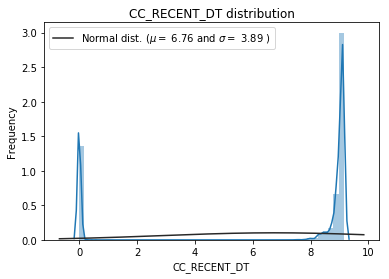

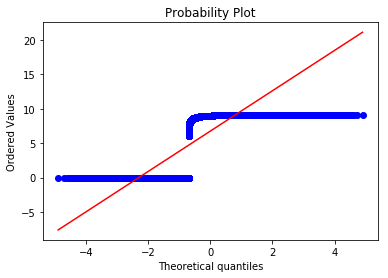

In [60]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
all_data["CC_RECENT_DT"] = np.log1p(all_data["CC_RECENT_DT"])

#Check the new distribution 
sns.distplot(all_data["CC_RECENT_DT"] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(all_data['CC_RECENT_DT'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('CC_RECENT_DT distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(all_data['CC_RECENT_DT'], plot=plt)
plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 4262.97 and sigma = 3355.09



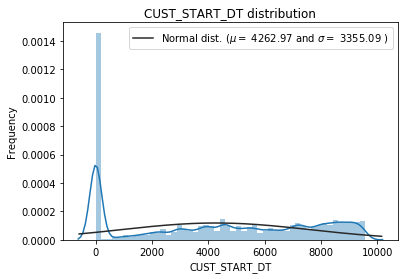

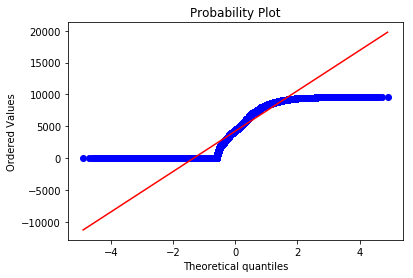

In [61]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
#all_data["CUST_START_DT"] = np.log1p(all_data["CC_RECENT_DT"])

#Check the new distribution 
sns.distplot(all_data["CUST_START_DT"] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(all_data['CUST_START_DT'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('CUST_START_DT distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(all_data['CUST_START_DT'], plot=plt)
plt.show()

In [62]:
## Standardization
num_feats = all_data.select_dtypes( include=['float64','float32','int'] ).columns
from sklearn import preprocessing
print(all_data[ num_feats ].head())
all_data[ num_feats ] = preprocessing.scale( all_data[ num_feats ] )
print(all_data[ num_feats ].head())
num_feats

                  CC_RECENT_DT  CUST_START_DT  FX_RECENT_DT  LN_RECENT_DT  \
CUST_NO                                                                     
AZTHNWQ_LXMGIMYG      0.000000         7945.0           0.0           0.0   
KCAFRIBOU9F2SSJW      8.763584            0.0           0.0           0.0   
JDVF4U8JUANEID68      9.107532         2484.0        9442.0           0.0   
JDVF4U8JUANEID68      9.107532         2484.0        9442.0           0.0   
JDVF4U8JUANEID68      9.107532         2484.0        9442.0           0.0   

                  TXN_DT  VISITDATE  WM_RECENT_DT  
CUST_NO                                            
AZTHNWQ_LXMGIMYG     0.0       9528           0.0  
KCAFRIBOU9F2SSJW     0.0       9511        8146.0  
JDVF4U8JUANEID68     0.0       9535        9442.0  
JDVF4U8JUANEID68     0.0       9537        9442.0  
JDVF4U8JUANEID68     0.0       9535        9442.0  
                  CC_RECENT_DT  CUST_START_DT  FX_RECENT_DT  LN_RECENT_DT  \
CUST_NO            

Index(['CC_RECENT_DT', 'CUST_START_DT', 'FX_RECENT_DT', 'LN_RECENT_DT',
       'TXN_DT', 'VISITDATE', 'WM_RECENT_DT'],
      dtype='object')

In [63]:
#DATA_30_60[DATA_30_60['y']==True]

In [96]:
all_data = pd.get_dummies(all_data)
all_data.shape

(1449418, 750)

In [97]:
# valid = all_data[:nvalid]
# yvalid = valid['y']
train = all_data[:ntrain]
ytrain = train['y']
test = all_data[ntrain:]


In [98]:
# valid = valid.drop(['y'], axis=1)
train = train.drop(['y'], axis=1)
test = test.drop(['y'], axis=1)

In [99]:
# print(valid.shape)
# print(yvalid.shape)
print(train.shape)
print(ytrain.shape)
print(test.shape)

(1251205, 749)
(1251205,)
(198213, 749)


In [100]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split


X_train1, X_test1, y_train1, y_test1 = train_test_split(train, ytrain, random_state = np.random.randint(1,999), test_size = 0.20) #

In [101]:
# X_train1, X_test1, y_train1, y_test1 = train, valid, ytrain, yvalid

In [102]:
print(X_train1.shape)
print(y_train1.shape)
print(X_test1.shape)
print(y_test1.shape)

(1000964, 749)
(1000964,)
(250241, 749)
(250241,)


In [103]:
# eval_set =  [(X_test1, y_test1)]
# model = XGBClassifier(base_score=0.1, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
#        max_depth=5, min_child_weight=5, missing=None, n_estimators=1000,
#        n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
#        reg_alpha=0.1, reg_lambda=1,  seed=None,
#        silent=True, subsample=0.9)
# model.fit(X_train1, y_train1, early_stopping_rounds=50, eval_metric="error", eval_set=eval_set,verbose=True)

In [104]:
eval_set =  [(X_test1, y_test1)]
model = XGBClassifier(scale_pos_weight=15,n_estimators=200, learning_rate=0.03,max_depth=3)


In [105]:
model.fit(X_train1, y_train1, eval_metric="error", eval_set=eval_set,verbose=True, early_stopping_rounds=20)

[0]	validation_0-error:0.04791
Will train until validation_0-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.04791
[2]	validation_0-error:0.043438
[3]	validation_0-error:0.043438
[4]	validation_0-error:0.043438
[5]	validation_0-error:0.043438
[6]	validation_0-error:0.043438
[7]	validation_0-error:0.043438
[8]	validation_0-error:0.043438
[9]	validation_0-error:0.043962
[10]	validation_0-error:0.043438
[11]	validation_0-error:0.042887
[12]	validation_0-error:0.038958
[13]	validation_0-error:0.041792
[14]	validation_0-error:0.038435
[15]	validation_0-error:0.040833
[16]	validation_0-error:0.038295
[17]	validation_0-error:0.038567
[18]	validation_0-error:0.037983
[19]	validation_0-error:0.0377
[20]	validation_0-error:0.037544
[21]	validation_0-error:0.036777
[22]	validation_0-error:0.036289
[23]	validation_0-error:0.036813
[24]	validation_0-error:0.035969
[25]	validation_0-error:0.034667
[26]	validation_0-error:0.034491
[27]	validation_0-error:0.033919
[28]	validation_0-error:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=15, seed=None,
       silent=True, subsample=1)

In [106]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
predicted=model.predict(X_test1)
print(accuracy_score(predicted, y_test1))

print(classification_report(y_test1,predicted ))
print(classification_report(predicted, y_test1 ))
print(confusion_matrix(y_test1,predicted))
confusion_matrix(predicted,y_test1)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9706962488161412
             precision    recall  f1-score   support

      False       0.98      0.99      0.99    245015
       True       0.22      0.15      0.18      5226

avg / total       0.97      0.97      0.97    250241

             precision    recall  f1-score   support

      False       0.99      0.98      0.99    246532
       True       0.15      0.22      0.18      3709

avg / total       0.98      0.97      0.97    250241

[[242107   2908]
 [  4425    801]]


array([[242107,   4425],
       [  2908,    801]])

In [75]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
predicted=model.predict(X_test1)
print(accuracy_score(predicted, y_test1))

print(classification_report(y_test1,predicted ))
print(classification_report(predicted, y_test1 ))
print(confusion_matrix(y_test1,predicted))
confusion_matrix(predicted,y_test1)

0.9555860666929635
             precision    recall  f1-score   support

      False       0.98      0.97      0.98    127259
       True       0.40      0.53      0.45      4569

avg / total       0.96      0.96      0.96    131828

             precision    recall  f1-score   support

      False       0.97      0.98      0.98    125654
       True       0.53      0.40      0.45      6174

avg / total       0.95      0.96      0.95    131828

[[123529   3730]
 [  2125   2444]]


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[123529,   2125],
       [  3730,   2444]])

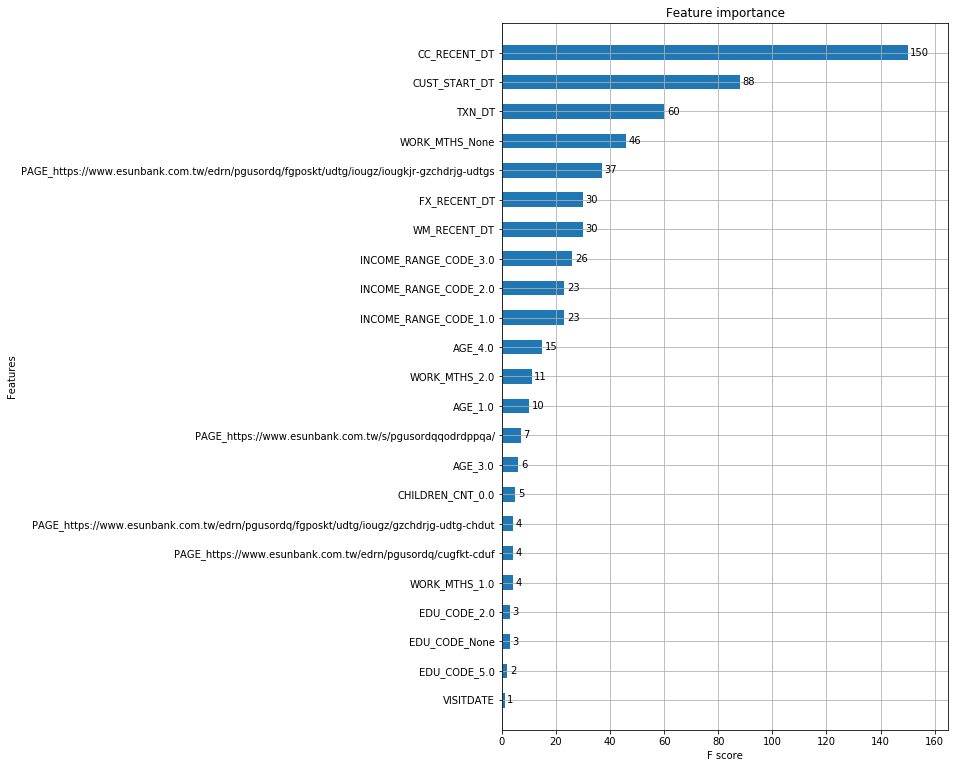

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=30, height=0.5, ax=ax)

In [108]:
if test.shape[1]>X_test1.shape[1]:
    test=test.drop('y',axis=1)

In [109]:
model.predict(test)
test['y'] = model.predict(test)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [110]:
test.shape

(198213, 750)

In [111]:
test.head()

,CC_RECENT_DT,CUST_START_DT,FX_RECENT_DT,LN_RECENT_DT,TXN_DT,VISITDATE,WM_RECENT_DT,AGE_1.0,AGE_2.0,AGE_3.0,...,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/gsxruoeot,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/gsxruoeot/,WORK_MTHS_1.0,WORK_MTHS_2.0,WORK_MTHS_3.0,WORK_MTHS_4.0,WORK_MTHS_5.0,WORK_MTHS_None,y
CUST_NO,,,,,,,,,,,,,,,,,,,,,
_PT5HFBEZJKOZ934,8658.0,2912.0,0.0,0.0,0.0,9553,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,False
_PT5HFBEZJKOZ934,8658.0,2912.0,0.0,0.0,0.0,9553,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,False
_PT5HFBEZJKOZ934,8658.0,2912.0,0.0,0.0,0.0,9553,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,False
_PT5HFBEZJKOZ934,8658.0,2912.0,0.0,0.0,0.0,9554,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,False
_PT5HFBEZJKOZ934,8658.0,2912.0,0.0,0.0,0.0,9562,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,False


In [112]:
test.groupby(test.index).max().shape

(30000, 750)

In [113]:
# 查看 test 資料預測為 True的數量
y_final = test.groupby(test.index, sort=False).max()
print(y_final[y_final['y']==True].shape[0])
y_final[y_final['y']==True]

1098


,CC_RECENT_DT,CUST_START_DT,FX_RECENT_DT,LN_RECENT_DT,TXN_DT,VISITDATE,WM_RECENT_DT,AGE_1.0,AGE_2.0,AGE_3.0,...,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/gsxruoeot,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/gsxruoeot/,WORK_MTHS_1.0,WORK_MTHS_2.0,WORK_MTHS_3.0,WORK_MTHS_4.0,WORK_MTHS_5.0,WORK_MTHS_None,y
CUST_NO,,,,,,,,,,,,,,,,,,,,,
J0DDOZLDFF03QBKW,9325.0,4996.0,9445.0,8162.0,0.0,9567,9441.0,0,0,1,...,0,0,0,1,0,0,0,0,0,True
PY7HZRT3G0LMU-TS,9317.0,9198.0,0.0,0.0,0.0,9548,0.0,0,1,0,...,0,0,0,1,0,0,0,0,0,True
ZTKERJNPX6TBF7Z4,0.0,9451.0,0.0,0.0,0.0,9540,0.0,0,0,1,...,0,0,0,1,0,0,0,0,0,True
FESPUGMORKUVWMDE,0.0,9267.0,0.0,8051.0,0.0,9540,0.0,0,0,0,...,0,0,0,0,1,0,0,0,0,True
KFR6LNV1U6PIUTHI,9219.0,9220.0,8104.0,0.0,0.0,9539,0.0,0,1,0,...,0,0,0,1,0,0,0,0,0,True
GYX6LCQUYB5DPCXI,9171.0,9172.0,0.0,0.0,0.0,9541,0.0,0,0,1,...,0,0,0,1,0,0,0,0,0,True
_ZSVVT1QSY562MFE,9346.0,9347.0,0.0,0.0,0.0,9567,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,True
OICGKXB8RPZE4R1K,9238.0,9071.0,0.0,0.0,9549.0,9555,0.0,1,0,0,...,0,0,0,1,0,0,0,0,0,True
J6EFECYX07AUGEZW,0.0,9512.0,0.0,0.0,0.0,9541,0.0,0,0,1,...,0,0,0,1,0,0,0,0,0,True


In [114]:
ans = pd.concat((TBN.groupby('CUST_NO').max(),y_final['y']),axis=1, join_axes=[y_final.index])
ans.head()

,CC_IND,FX_IND,LN_IND,WM_IND,y
CUST_NO,,,,,
_PT5HFBEZJKOZ934,0,0,0,0,False
6STXUMWZRDCGSDDU,0,0,0,0,False
JDVF4U8JUANEID68,0,0,0,0,False
8I6SQDGP9OQYUN1M,0,0,0,0,False
R-TRDUV3GHTID31I,0,0,0,0,False


In [115]:
ans['CC_IND']=ans['y']

In [116]:
ans = ans.drop('y', axis=1)

In [117]:
ans.to_csv('CC.csv')

In [100]:
test['y']

CUST_NO
_PT5HFBEZJKOZ934    False
_PT5HFBEZJKOZ934    False
_PT5HFBEZJKOZ934    False
_PT5HFBEZJKOZ934    False
_PT5HFBEZJKOZ934    False
_PT5HFBEZJKOZ934    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
JDVF4U8JUANEID68    False
JDVF4U8JUANEID68    False
JDVF4U8JUANEID68    False
JDVF4U8JUANEID68    False
JDVF4U8JUANEID68    False
JDVF4U8JUANEID68    False
8I6SQDGP9OQYUN1M    False
R-TRDUV3GHTID31I    False
R-TRDUV3GHTID31I    False
J0DDOZLDFF03QBKW    False
J0DDOZLDFF03QBKW    False
HWAZJ_IO2-GACG_C    False
                    ...  
GBGSO4CV37Q9HUGM    False
GBGSO4CV37Q9HUGM    False
GBGSO4CV37Q9HUGM    False
GBGSO4CV37Q9HUGM    False
GBGSO4CV37Q9HUGM    False
2RZMYWSGN0NOMPS4    False
2RZMYWSGN0NOMPS4    False
2RZM